In [38]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import seaborn as sns

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [32]:
os.chdir('/content/gdrive/My Drive/placement/IIBM')
data = pd.read_csv('tumor_data.csv')
label = pd.read_csv('tumor_labels.csv')

In [34]:
#splitting the model into training and testing set
nfeat=30
X=np.loadtxt('tumor_data.csv', delimiter=',', converters=None, skiprows=1, usecols=range(1,nfeat), unpack=False, ndmin=0, )
from sklearn import preprocessing
#print(X)
scaler = preprocessing.StandardScaler().fit(X)
X= scaler.transform(X)
y=np.genfromtxt('tumor_labels.csv',dtype='str',skip_header=1,usecols=[1],delimiter=',')
df = pd.DataFrame(X,columns=np.arange(1,nfeat))
label=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    label, test_size=0.30, 
                                                    random_state=101)

In [35]:
#training a logistics regression model
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print("Accuracy = "+ str(accuracy_score(y_test,predictions)))


Accuracy = 0.8506224066390041


In [36]:
#defining various steps required for the genetic algorithm
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)
        #print chromosome
        #chromosome[:int(0.3*n_feat)]=False
        chromosome[:int(0.95*nfeat)]=False
        #print chromosome,"then"
        np.random.shuffle(chromosome)
        population.append(chromosome)
    
    return population

def fitness_score(population):
    scores = []
    for chromosome in population:
        if sum(chromosome)==0:
            chromosome[0]=True
        #print chromosome,sum(chromosome)
        logmodel.fit(X_train.iloc[:,chromosome],y_train)
        predictions = logmodel.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)
    #print scores,"here"
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

def crossover(pop_after_sel):
    population_nextgen=pop_after_sel
    for i in range(len(pop_after_sel)):
        child=pop_after_sel[i]
        child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
        population_nextgen.append(child)
    return population_nextgen

def mutation(pop_after_cross,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_cross)):
        chromosome = pop_after_cross[i]
        for j in range(len(chromosome)):
            if random.random() < mutation_rate:
                chromosome[j]= not chromosome[j]
        population_nextgen.append(chromosome)
    #print(population_nextgen)
    return population_nextgen

def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, y_train, y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        #print(scores[:2])
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
        #print sum(pop_after_fit[0])
    return best_chromo,best_score

In [37]:
chromo,score=generations(size=200,n_feat=nfeat-1,n_parents=100,mutation_rate=0.010,n_gen=38,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
print("Accuracy score after genetic algorithm is= "+str(accuracy_score(y_test,predictions)))
cm = confusion_matrix(y_test, predictions)
cm

Accuracy score after genetic algorithm is= 0.8713692946058091


array([[68,  4,  1,  6,  3],
       [ 1, 23,  0,  0,  0],
       [ 0,  0, 49,  0,  0],
       [10,  0,  0, 30,  1],
       [ 5,  0,  0,  0, 40]])

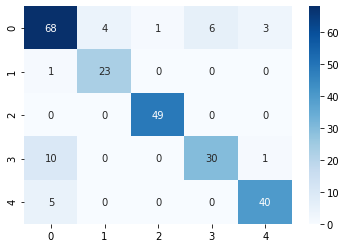

In [40]:
sns.heatmap(cm,annot=True,cmap='Blues')